# Imports


In [112]:
import numpy as np
# Import opencv for computer vision
import cv2 
# Import matplotlib to visualize an image
from matplotlib import pyplot as plt
from __future__ import print_function
import sys
from random import randint
import cv2.aruco as aruco


# Computer Vision


## Past attempts:

Potential solutions:
1. Using Tensorflow
https://www.youtube.com/watch?v=yqkISICHH-U

2. Using MultiTracker OpenCV
https://learnopencv.com/multitracker-multiple-object-tracking-using-opencv-c-python/

### Using MultiTracker OpenCV


Start by creating a single object tracker
- below doesnt work

Read the first frame of livestream
* May need to modify

Locate objects in the first frame

Check out
https://www.youtube.com/watch?v=8ktcGQ-XreQ

Perhaps use YOLOv5:
https://blog.paperspace.com/train-yolov5-custom-data/


https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/


## 1. Setting up Aruco

### Markers detected in real time:


Code referenced from:
https://docs.opencv.org/4.8.0/d5/dae/tutorial_aruco_detection.html

In [19]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
       
    # If aruco markers are detected:
    if np.all(ids is not None):  
        for i in range(0, len(ids)):  
                 aruco.drawDetectedMarkers(frame, corners) 
                    
                    
    cv2.imshow('frame', frame)
        
    key = cv2.waitKey(3) & 0xFF
    if key == ord('q'):  
        break
    
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


### Getting marker coordinates


Thymio: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 0
<br>
Obstacles:&nbsp;&nbsp;&nbsp;indicies 1-6
<br>
Goal:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 7

In [ ]:
def current_photo():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cv2.imwrite('images/current.jpg', frame)
    cap.release()

In [ ]:
current_photo()

The following functions below retrieve the first photo, and utilize it to locate the coordinates of the markers.


In [113]:
def get_Thymio():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)

    # If aruco markers are detected:
    #if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
            
    # Get thymio at idx 0  
    idx = np.where(ids == 0)[0][0]
    coords = corners[idx]
    
    # Get center coordinates to return
    x1 = coords[0][0][0]
    y1 = coords[0][0][1]
    x2 = coords[0][2][0]
    y2 = coords[0][2][1]
    
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    
    center = [x_center, y_center]

    return center

In [114]:
center_thymio = get_Thymio()
print(center_thymio)

[186.5, 114.5]


In [115]:
def get_goal():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get goal at idx 7  
    idx = np.where(ids == 7)[0][0]
    coords = corners[idx]
    
    
#         idx = np.where((ids != 0) & (ids != 7))[0]
#     coord = [corners[i].tolist() for i in idx]
    
#     id = ids[idx]

    
#     coords_list = []

#     for i in coord:    
#         ul_x = i[0][0][0]
#         ul_y = i[0][0][1]

#         ur_x = i[0][1][0]
#         ur_y = i[0][1][1]

#         br_x = i[0][2][0]
#         br_y = i[0][2][1]

#         bl_x = i[0][3][0]
#         bl_y = i[0][3][1]

#         coords_list.append([ul_x, ul_y, ur_x, ur_y, bl_x, bl_y, br_x, br_y])
        
        
    # Get center coordinates to return
    x1 = coords[0][0][0]
    y1 = coords[0][0][1]
    x2 = coords[0][2][0]
    y2 = coords[0][2][1]
    
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    
    center = [x_center, y_center]
    
    return center

In [116]:
center_goal = get_goal()
print(center_goal)

[526.5, 280.0]


In [117]:
def get_obst():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get obstacles at idx that is not Thymio or goal 
    idx = np.where((ids != 0) & (ids != 7))[0]
    coord = [corners[i].tolist() for i in idx]
    
    id = ids[idx]

    
    coords_list = []

    for i in coord:    
        ul_x = i[0][0][0]
        ul_y = i[0][0][1]

        ur_x = i[0][1][0]
        ur_y = i[0][1][1]

        br_x = i[0][2][0]
        br_y = i[0][2][1]

        bl_x = i[0][3][0]
        bl_y = i[0][3][1]

        coords_list.append([ul_x, ul_y, ur_x, ur_y, bl_x, bl_y, br_x, br_y])
        
    # Sort coords based on id
    coords = [x for y, x in sorted(zip(id, coords_list))]
    return coords

In [118]:
obstacle_coord = get_obst()
print(obstacle_coord)

[[107.0, 288.0, 121.0, 288.0, 107.0, 303.0, 121.0, 303.0], [269.0, 353.0, 283.0, 351.0, 270.0, 367.0, 284.0, 366.0], [407.0, 214.0, 392.0, 216.0, 406.0, 200.0, 391.0, 201.0]]


# Path Planning

## 1. Dijkstra Algorithm

I am still fine-tuning the computer vision code. For now, use this image as a reference and and these coordinates to begin working on the algorithm.

Img height: 640
Img width: 640

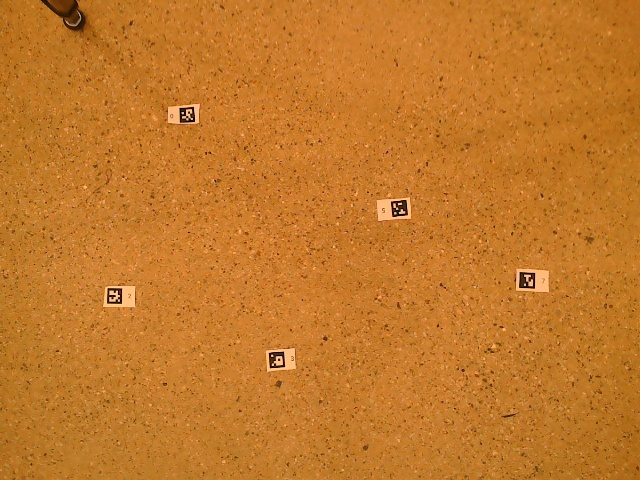

In [119]:
from PIL import Image

from dijkstar import Graph, find_path
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt


path="images/current.jpg"
display(Image.open(path))

filepath = "images/current.jpg"
img = Image.open(filepath) 
  
# get width and height 
width = img.width 
height = img.height


{
    "boxes": [
        {
            "label": "obstacle",
            "x": 129,
            "y": 180.5,
            "width": 118,
            "height": 207.5
        },
        {
            "label": "obstacle",
            "x": 284.5,
            "y": 517.5,
            "width": 116.5,
            "height": 203.5
        },
        {
            "label": "obstacle",
            "x": 412.5,
            "y": 254,
            "width": 91.5,
            "height": 162
        },
        {
            "label": "goal",
            "x": 556,
            "y": 203,
            "width": 44,
            "height": 78
        },
        {
            "label": "Thymio",
            "x": 151,
            "y": 413,
            "width": 125,
            "height": 215.5
        }
    ],
    "height": 640,
    "key": "arena (8).jpg",
    "width": 640
}

In [120]:
obs_nbr = len(obstacle_coord)
node_coord_x=[]
node_coord_y=[]
max_coord_y=height

import math

def distance(node1,node2):
    distance=math.sqrt((node_coord_x[node2]-node_coord_x[node1])**2+(node_coord_y[node2]-node_coord_y[node1])**2)
    distance=round(distance,2)
    return distance
def distance_goal_node(goal,node):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance

def distance_node_goal(node,goal):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance


for obstacle in range(obs_nbr):
    for corner_high in range(2):
        node_coord_y.append(obstacle_coord[obstacle][(2*corner_low)+5]/2)
        node_coord_x.append(obstacle_coord[obstacle][(2*corner_high)])
    for corner_low in range(2):
        node_coord_y.append(max_coord_y-((max_coord_y-obstacle_coord[obstacle][(2*corner_high)+1])/2))
        node_coord_x.append(obstacle_coord[obstacle][(2*corner_low)+4])

def draw_graph(graph_data):
    # Créer un objet Graph avec networkx
    G = nx.Graph()

    # Ajouter des nœuds et des liens au graphique
    for node, edges in graph_data.items():
        G.add_node(node)
        for neighbor, weight in edges.items():
            G.add_edge(node, neighbor, weight=weight)

    # Dessiner le graphique
    pos = nx.spring_layout(G)  # position des nœuds pour un aspect plus lisible
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Afficher le graphique
    plt.show()

graph = Graph ()
def connect_nodes(obs_nbr):     
    for nb_node in range(obs_nbr*4-1):
        if nb_node % 2 == 0:
            graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))
            if nb_node > 3:
                graph.add_edge(nb_node, nb_node -3, distance(nb_node, nb_node -3))
        else:
            graph.add_edge(nb_node, nb_node - 1, distance(nb_node, nb_node - 1))
            if nb_node < (obs_nbr-1)*4:
                graph.add_edge(nb_node, nb_node + 3, distance(nb_node, nb_node + 3))
                if (nb_node-1) % 4 == 0:
                    graph.add_edge(nb_node, nb_node + 5, distance(nb_node, nb_node + 5))
                else:
                    graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))
                    
    # draw_graph(graph)
    # shortest_path = find_path(graph, 0, 2)
    # print(shortest_path)   
    # return graph


break
1 0
2
6


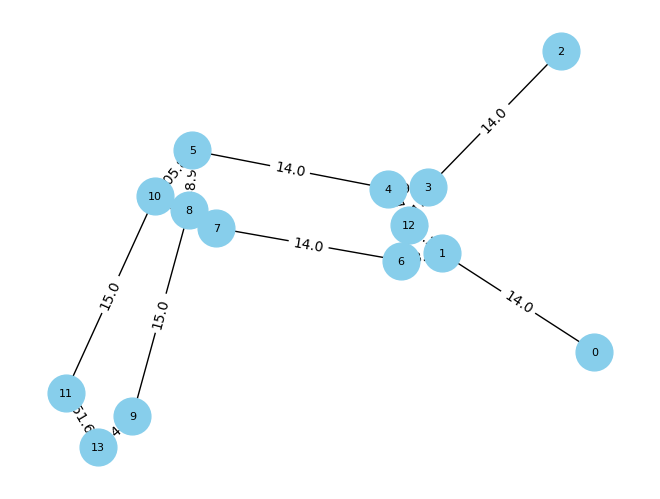

PathInfo(nodes=[12, 4, 5, 10, 11, 13], edges=[107.23, 14.0, 205.8, 15.0, 151.61], costs=[107.23, 14.0, 205.8, 15.0, 151.61], total_cost=493.64000000000004)


In [121]:
goal_coord_x=[center_thymio[0],center_goal[0]]   
goal_coord_y=[center_thymio[1],center_goal[1]]
thymio=100
goal=101
offset=obs_nbr*4

def localisation(object):
    column=0
    break_flag=0
    for obstacle in range(obs_nbr):
        for corner in range(2):
            
            if goal_coord_x[object]<obstacle_coord[obstacle][(2*corner)]:
                print("break")
                print(obstacle,corner)
                break_flag=1
                break
            column+=1
        if break_flag==1:
            break
            
    print(column)
    if column % 2 == 0:
    
        if column < 2 * obs_nbr:
            graph.add_edge(object + offset, 2 * column, distance_goal_node(object, 2 * column))
            graph.add_edge(2 * column, object + offset, distance_node_goal(2 * column, object))

            graph.add_edge(object + offset, 2 * column + 2, distance_goal_node(object, 2 * column + 2))
            graph.add_edge(2 * column + 2, object + offset, distance_node_goal(2 * column + 2, object))
    
        if column > 0:
            graph.add_edge(object + offset, 2 * column - 1, distance_goal_node(object, 2 * column - 1))
            graph.add_edge(2 * column - 1, object + offset, distance_node_goal(2 * column - 1, object))

            graph.add_edge(object + offset, 2 * column - 3, distance_goal_node(object, 2 * column - 3))
            graph.add_edge(2 * column - 3, object + offset, distance_node_goal(2 * column - 3, object))
  
    else:
        if goal_coord_y[object] > obstacle_coord[math.floor((column - 1) / 2)][1]:
            graph.add_edge(object + offset, (2 * column) - 1, distance_goal_node(object, (2 * column) - 1))
            graph.add_edge((2 * column) - 1, object + offset, distance_node_goal((2 * column) - 1, object))

            graph.add_edge(object + offset, (2 * column) - 2, distance_goal_node(object, (2 * column) - 2))
            graph.add_edge((2 * column) - 2, object + offset, distance_node_goal((2 * column) - 2, object))
        else:
            graph.add_edge(object + offset, (2 * column), distance_goal_node(object, (2 * column)))
            graph.add_edge((2 * column), object + offset, distance_node_goal((2 * column), object))

            graph.add_edge(object + offset, (2 * column) + 1, distance_goal_node(object, (2 * column) + 1))
            graph.add_edge((2 * column) + 1, object + offset, distance_node_goal((2 * column) + 1, object))

connect_nodes(obs_nbr)
localisation(0)
localisation(1)

draw_graph(graph)
shortest_path = find_path(graph, 12, 13)
print(shortest_path)
            


In [104]:
clear()